In [1]:
from keras.layers import Embedding, Dense, Dropout, Input#, LSTM, Bidirectional
from keras.layers import MaxPooling1D, Conv1D, Flatten, LSTM
from keras.preprocessing import sequence#, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors

from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix as confmat,
    classification_report as creport
)

from utils import *

np.random.seed(42)

Using TensorFlow backend.


## Language Model and Data

In [2]:
algo = 'sg' # or 'cbow'
path = './arabic_bins/web_{}_300'.format(algo)
#path = './arabic_bins/cc.ar.300.vec'

In [3]:
# language model
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(path)#, ext='vec')

# load data
data_paths = ['./data/arabic_dataset_classifiction.csv']
x_train, x_test, y_train, y_test, MAX_TEXT_LENGTH = split_datasets(data_paths, test_size=0.2, seed=42)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))

# 
x_train, x_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, 
                                                                            y_train, y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Dataset splited.
Label categories: ['0' '1' '2' '3' '4']
Converting data to trainable form...
Number of training examples: 89382
Number of testing examples: 22346


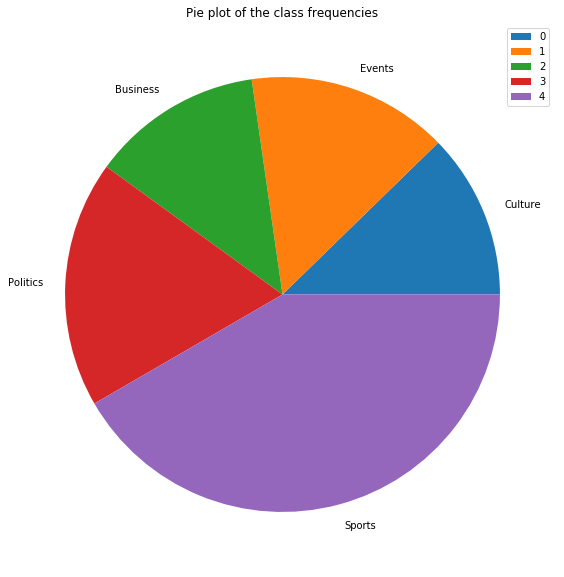

In [4]:
LABELS = (
    'Culture', 'Events', 'Business', 'Politics', 'Sports'
)

tmp = np.concatenate((y_train, y_test))
unique, counts = np.unique(tmp, return_counts=True)
del tmp
plt.figure("Target Pie", figsize=(10, 10))
plt.title("Pie plot of the class frequencies")
plt.pie(counts, labels=LABELS)
plt.legend(unique)
plt.savefig("./img/stats_classes.png")
plt.show();

**Try less timesteps**

In [5]:
# Sequence length
print("Original sequence length : "+str(MAX_TEXT_LENGTH))

# CHANGE MAX LENGTH (timesteps)
MAX_TEXT_LENGTH = 2000

Original sequence length : 5049


In [6]:
def get_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    """
    DOC
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)
    model = LSTM(units=32, return_sequences=True, return_state=False)(model)
    model = Dropout(0.1)(model)
    
    model = LSTM(units=16, return_sequences=True, return_state=False)(model)
    model = Dropout(0.1)(model)
        
    model = Flatten()(model)
        
    model = Dense(200, activation='relu')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(5, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH):
    """
    DOC
    """
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_test, y_train, y_test, batch_size, epochs, TestCallback=TestCallback):
    """
    DOC 
    """
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test))#,
                        #callbacks=[TestCallback((x_test, y_test))])
    return history, model

In [7]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH)

Building embedding matrix...
Embedding matrix built.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2000, 300)         115239600 
_________________________________________________________________
lstm_1 (LSTM)                (None, 2000, 32)          42624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2000, 16)          3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2000, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)    

In [8]:
del WORD_MODEL
del word_index

## Start Learning

In [10]:
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y,
                               batch_size=500, epochs=150)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Train on 89382 samples, validate on 22346 samples
Epoch 1/150
89382/89382 [==============================] - 679s 8ms/step - loss: 1.3422 - acc: 0.4401 - val_loss: 1.0036 - val_acc: 0.5820
Epoch 2/150
89382/89382 [==============================] - 679s 8ms/step - loss: 0.7993 - acc: 0.6905 - val_loss: 0.5856 - val_acc: 0.7988
Epoch 3/150
89382/89382 [==============================] - 680s 8ms/step - loss: 0.5170 - acc: 0.8186 - val_loss: 0.4611 - val_acc: 0.8292
Epoch 4/150
89382/89382 [==============================] - 681s 8ms/step - loss: 0.4024 - acc: 0.8676 - val_loss: 0.3619 - val_acc: 0.8846
Epoch 5/150
89382/89382 [==============================] - 680s 8ms/step - loss: 0.3461 - acc: 0.8904 - val_loss: 0.3335 - val_acc: 0.8954
Epoch 6/150
89382/89382 [==============================] - 677s 8ms/step - loss: 0.3132 - acc: 0.9009 - val_loss: 0.3058 - val_acc: 0.9093
Epoch 7/150
89382/89382 [==============================] - 678s 8ms/step - loss: 0.2894 - acc: 0.9095 - val_loss: 0.

89382/89382 [==============================] - 680s 8ms/step - loss: 0.1728 - acc: 0.9460 - val_loss: 0.1841 - val_acc: 0.9423
Epoch 60/150
89382/89382 [==============================] - 678s 8ms/step - loss: 0.1716 - acc: 0.9457 - val_loss: 0.1866 - val_acc: 0.9419
Epoch 61/150
89382/89382 [==============================] - 676s 8ms/step - loss: 0.1701 - acc: 0.9462 - val_loss: 0.1839 - val_acc: 0.9413
Epoch 62/150
89382/89382 [==============================] - 682s 8ms/step - loss: 0.1700 - acc: 0.9465 - val_loss: 0.1823 - val_acc: 0.9415
Epoch 63/150
89382/89382 [==============================] - 672s 8ms/step - loss: 0.1696 - acc: 0.9464 - val_loss: 0.1799 - val_acc: 0.9435
Epoch 64/150
89382/89382 [==============================] - 675s 8ms/step - loss: 0.1688 - acc: 0.9467 - val_loss: 0.1829 - val_acc: 0.9416
Epoch 65/150
89382/89382 [==============================] - 678s 8ms/step - loss: 0.1682 - acc: 0.9465 - val_loss: 0.1805 - val_acc: 0.9431
Epoch 66/150
89382/89382 [=======

89382/89382 [==============================] - 677s 8ms/step - loss: 0.1532 - acc: 0.9511 - val_loss: 0.1738 - val_acc: 0.9449
Epoch 118/150
89382/89382 [==============================] - 680s 8ms/step - loss: 0.1534 - acc: 0.9514 - val_loss: 0.1741 - val_acc: 0.9449
Epoch 119/150
89382/89382 [==============================] - 677s 8ms/step - loss: 0.1528 - acc: 0.9513 - val_loss: 0.1743 - val_acc: 0.9453
Epoch 120/150
89382/89382 [==============================] - 677s 8ms/step - loss: 0.1523 - acc: 0.9522 - val_loss: 0.1788 - val_acc: 0.9438
Epoch 121/150
89382/89382 [==============================] - 677s 8ms/step - loss: 0.1525 - acc: 0.9512 - val_loss: 0.1742 - val_acc: 0.9454
Epoch 122/150
89382/89382 [==============================] - 680s 8ms/step - loss: 0.1520 - acc: 0.9517 - val_loss: 0.1736 - val_acc: 0.9456
Epoch 123/150
89382/89382 [==============================] - 678s 8ms/step - loss: 0.1520 - acc: 0.9520 - val_loss: 0.1761 - val_acc: 0.9440
Epoch 124/150
89382/89382 [

In [11]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])

In [12]:
model.evaluate(x_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

22346/22346 [==============================] - 50s 2ms/step


[0.17343738219667162, 0.9458516004592764]

In [ ]:
y_pred = np.argmax(model.predict(x_test[:, :MAX_TEXT_LENGTH]), axis=1)
# y_pred = np_utils.to_categorical(np.argmax(y_pred, axis=1), len(CLASSES_LIST))

cm = confmat(np.argmax(test_cat_y, axis=1), y_pred)

print("Confusion Matrix :\n\n {}\n".format(cm))
print(creport(np.argmax(test_cat_y, axis=1), y_pred))

**Early Stopping**

In [13]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['acc'][n]*100, 2)))
print("Accuracy on test : {} %".format(np.round(history.history['val_acc'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on test : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 147
Accuracy on train : 95.34 %
Accuracy on test : 94.57 %
Loss on train : 14.7
Loss on test : 17.24


In [ ]:
"""
LSTM simple (une seule couche, ne dépasse pas  :

Accuracy on train : 95.36 %
Accuracy on test : 94.61 %
Loss on train : 14.54
Loss on test : 17.18
""";

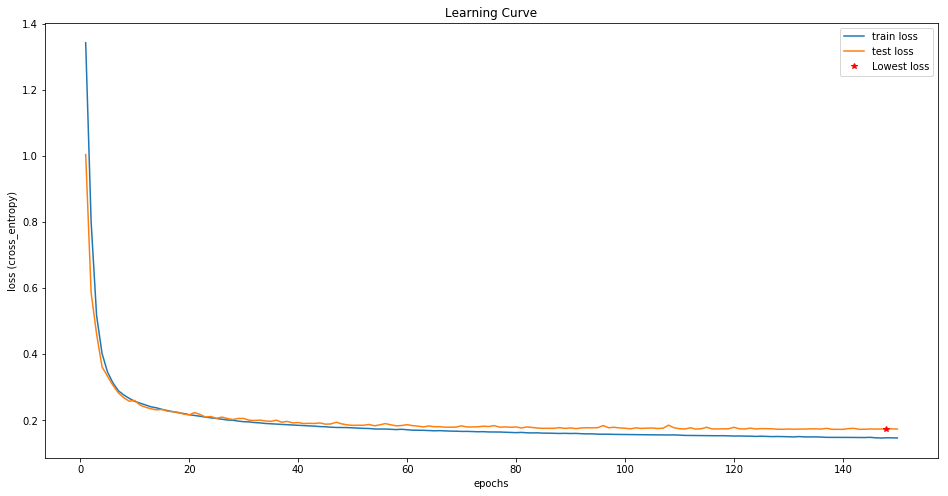

In [17]:
plt.figure("Loss Plot", figsize=(16, 8))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="test loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.savefig("./img/RNN_loss_500_2000_sg_false_150.png")
plt.show();

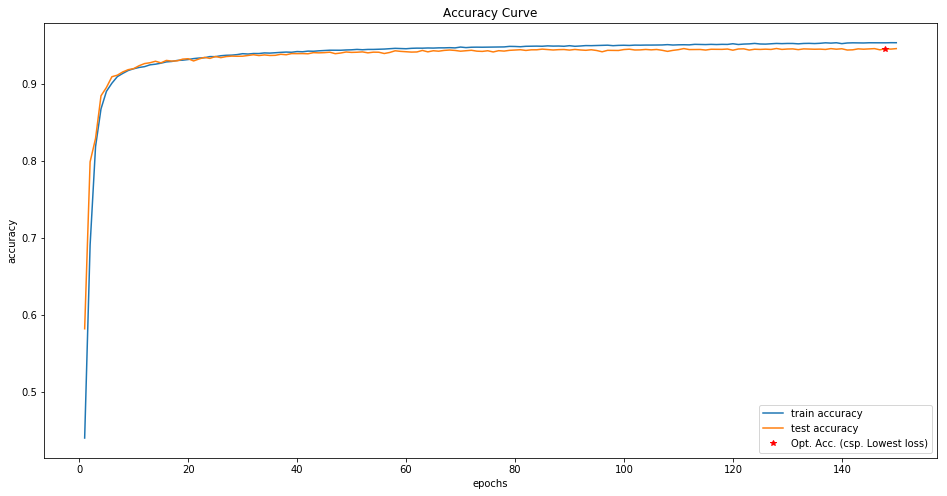

In [18]:
plt.figure("Accuracy Plot", figsize=(16, 8))
plt.plot(range(1, len(history.history['acc'])+1), history.history['acc'], label="train accuracy")
plt.plot(range(1, len(history.history['val_acc'])+1), history.history['val_acc'], label="test accuracy")
plt.plot(n+1,history.history["val_acc"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.savefig("./img/RNN_acc_500_2000_sg_false_150.png")
plt.show()

## Save results

In [16]:
import shelve

tmp = shelve.open('lstm_results')
tmp['history'] = history.history
tmp.close()

## Recompute results

In [38]:
import shelve

tmp_list = []
tmp = shelve.open('fasttext')
for i in range(1,11):
    histo_tmp = tmp[str(i)]
    n = np.argmin(histo_tmp['val_loss'])
    tmp_list.append(np.round(histo_tmp['acc'][n]*100, 2))
tmp.close()

In [39]:
np.std(tmp_list)

0.009165151389911407